# Rozpoznawanie polskich znaków

Import wymaganych bibliotek, sprawdzenie GPU

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import shutil, random
from sklearn.metrics import confusion_matrix
from skimage import io
import itertools


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Globalne zmienne

In [2]:
# Ścieżka z folderem z danymi
data_path = os.path.join(os.getcwd(), 'data')
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')
valid_path = os.path.join(data_path, 'valid')

# Rozmiar docelowy zdjęć
image_size = 64
# Liczba próbek propagowanych przez sieć (mniej Ram, szybsza)
batch_size = 32

# Klasy takie jak nazwy folderów
classes = os.listdir(train_path)

# Ile % zdjęć ma byc przeniesionych do folderu zawierającego zdj walidujące przy uczeniu modelu
validation_split_dataset = 0.1

# Liczba epok
epochs = 25

Wybranie obrazów walidujących.

Rozwiązanie problemu:
```python
ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found following types in the input: [<class 'tensorflow.python.keras.preprocessing.image.DirectoryIterator'>]
```

In [3]:
if os.path.isdir(valid_path) is False:
    os.makedirs(valid_path)
    for class_dir in os.listdir(train_path):
        print('=', end='')
        src_dir = os.path.join(train_path, class_dir)
        dest_dir = os.path.join(valid_path, class_dir)
        os.makedirs(dest_dir)        
        elementy_w_folderze = os.listdir(src_dir)
        ile_elementow = len(elementy_w_folderze) 
        for i in random.sample(range(0, ile_elementow), int(ile_elementow*validation_split_dataset)):
            shutil.move(os.path.join(src_dir, elementy_w_folderze[i]) , dest_dir)
        
            

## Przedstawienie datasetu

In [4]:
def load_data(data_dir):
    directories = [d for d in os.listdir(train_path)
                   if os.path.isdir(os.path.join(train_path, d))]
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(train_path, d)
        file_names = [os.path.join(label_dir, f)
                      for f in os.listdir(label_dir) if f.endswith(".jpg")]
        for f in file_names:
            #print(f)
            images.append(io.imread(f))
            labels.append(int(d))
    return images, labels

Ilość danych i zmiennych decyzyjnych

In [5]:
global_labels = pd.read_csv('./data/labels.csv', delimiter=',')
images, labels = load_data(train_path)

print("Ilość klas: {0}\nIlość danych testowych: {1}".format(len(set(labels)), len(images)))

Ilość klas: 92
Ilość danych testowych: 15116


Prezentacja klas.

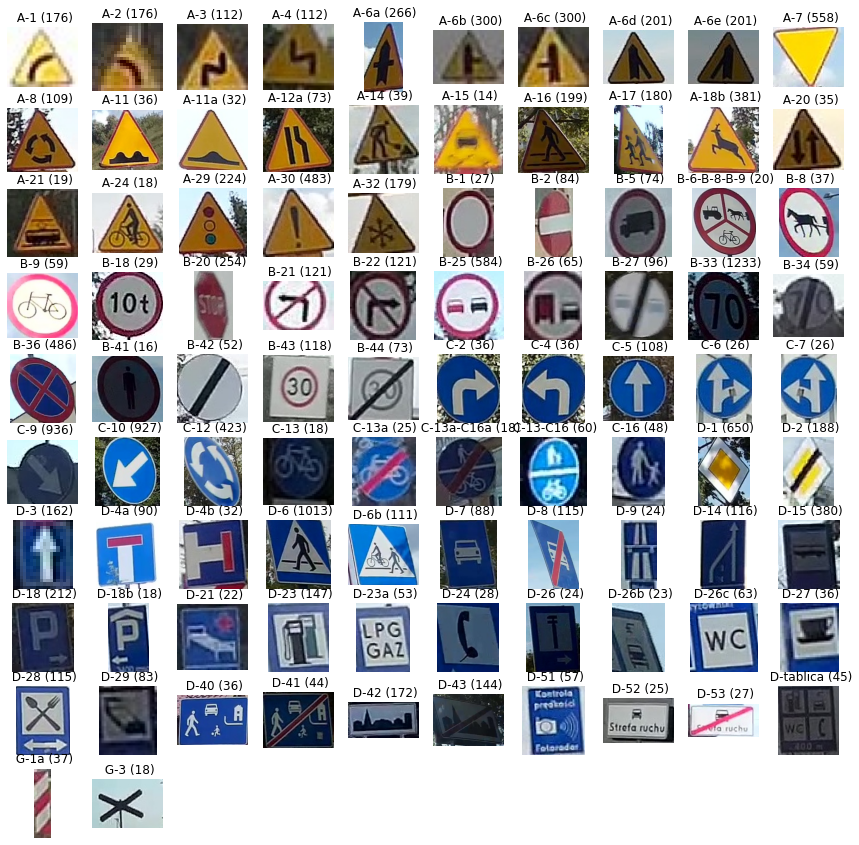

In [6]:
def display_images_and_labels(images, labels):
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        image = images[labels.index(label)]
        plt.subplot(10, 10, i) # X - Y
        plt.axis('off')
        plt.title(" {0} ({1})".format(global_labels["Sign"][int(label)], labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

Przedstawienie zawartości poszczególnych klas.

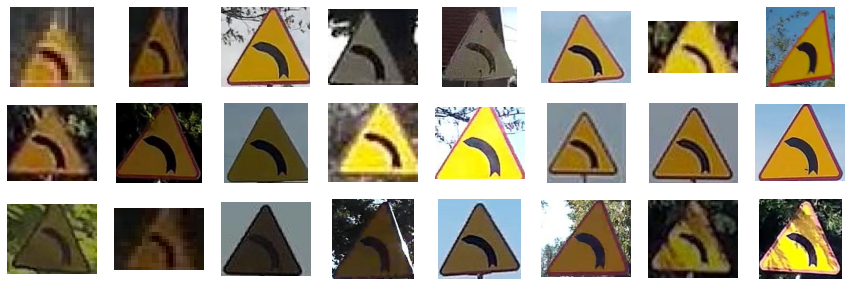

In [7]:
def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # max 24
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 x 8
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images, 1)

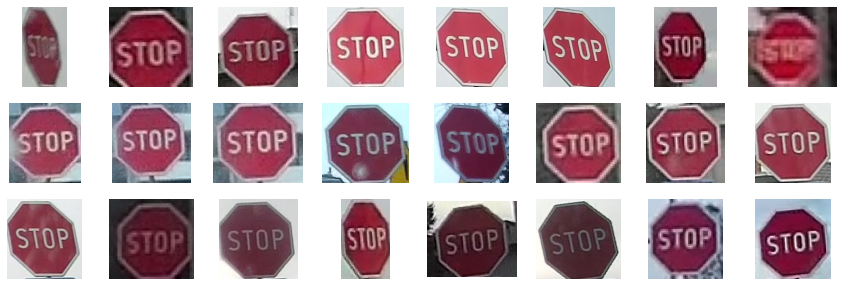

In [11]:
display_label_images(images, 32)

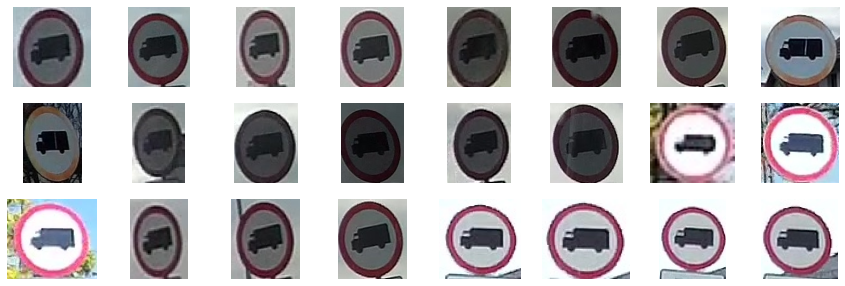

In [9]:
display_label_images(images, 27)

Jaki jest rozmiar naszych danych?

In [10]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (21, 25, 3), min: 0, max: 255
shape: (44, 48, 3), min: 0, max: 237
shape: (53, 61, 3), min: 0, max: 164
shape: (213, 194, 3), min: 0, max: 166
shape: (34, 29, 3), min: 0, max: 213


## Wczytywanie obrazów

ImageDataGenerator odrazu dokonuje powiększenia zbioru stosując np. przesunięcie, skalowanie, rotacje itp

In [108]:
train_batches = ImageDataGenerator() \
    .flow_from_directory(directory=train_path, target_size=(image_size, image_size), classes=classes, batch_size=batch_size)
    
valid_batches = ImageDataGenerator() \
    .flow_from_directory(directory=valid_path, target_size=(image_size, image_size), classes=classes, batch_size=batch_size)
    
test_batches = ImageDataGenerator() \
    .flow_from_directory(directory=test_path, target_size=(image_size, image_size), classes=classes, batch_size=batch_size, shuffle=False)

Found 15116 images belonging to 92 classes.
Found 1630 images belonging to 92 classes.
Found 4298 images belonging to 92 classes.


Pokaż zdjęcia

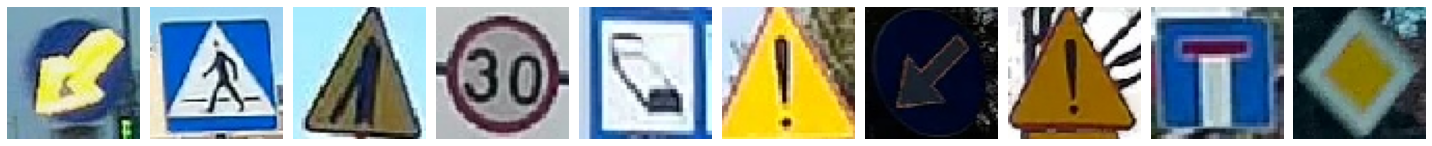

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [109]:
imgs, local_class = next(train_batches)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img.astype('uint8'))
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(imgs)
print(local_class)
    

Budowanie modelu

In [110]:
#Building the model
model = Sequential() # sequelntial otrzymuje dane kiedy wywołujemy funkcję celu na niej

model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(image_size, image_size, 3)))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=len(classes), activation='softmax'))
#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 60, 60, 32)        2432      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 26, 26, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)       

Trenowanie

In [111]:
anc = model.fit(x=train_batches, batch_size=batch_size, epochs=epochs, validation_data=valid_batches)

Epoch 1/25
141/473 [=======>......................] - ETA: 1:25 - loss: 4.8717 - accuracy: 0.3167

KeyboardInterrupt: 

Zapis modelu do pliku

In [ ]:
model.save('traffic_classifier.h5')

Statystyki wytrenowanego modelu

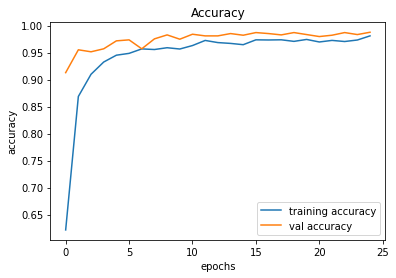

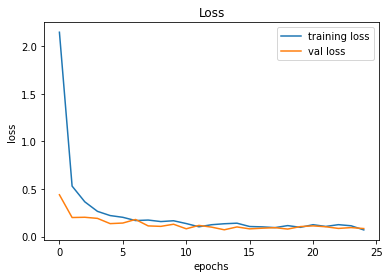

In [ ]:
plt.figure(0)
plt.plot(anc.history['accuracy'], label='training accuracy')
plt.plot(anc.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(anc.history['loss'], label='training loss')
plt.plot(anc.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Predykcja

In [ ]:
score = model.evaluate(test_batches, verbose = 1) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

135/135 [==============================] - 19s 134ms/step - loss: 0.2393 - accuracy: 0.9567
Test loss: 0.2393294721841812
Test accuracy: 0.9567240476608276


In [ ]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
#print(test_labels)
test_batches.classes

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]


ValueError: too many values to unpack (expected 2)

Macierz pokazująca na osiach dane testujące i predykcję

Przekątna macierzy wskazuje dopasowanie tj model poprawnie przewiduje

Wykres pokazuje częstotliwość w zakresie 0 do 5

In [ ]:
# Pick 10 random images
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = session.run([predicted_labels],
                        feed_dict={images_ph: sample_images})[0]
print(sample_labels)
print(predicted)

IndexError: tuple index out of range

In [ ]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(test_batches)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction),
             fontsize=12, color=color)
    plt.imshow(sample_images[i])

NameError: name 'sample_images' is not defined

<Figure size 720x720 with 0 Axes>

In [ ]:
predictions = model.predict(x=test_batches)
np.round(predictions)
plt.rcParams["figure.figsize"] = [40.,40.]
plt.rcParams["figure.autolayout"] = True
cm = confusion_matrix(y_true=test_batches.classes, y_pred=predictions.argmax(axis=-1))
plt.imshow(cm, cmap='Greys',  interpolation='nearest', vmin=0, vmax=5)


Otwieranie modelu

In [112]:
from tensorflow.keras.models import load_model
model = load_model('traffic_classifier.h5')